In [232]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

g = torch.Generator().manual_seed(42)

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
block_size = 3 # context size 

def build_dataset(words):
    ins, outs = [], []

    for w in words:
        context = [0] * block_size  # init empty context for first word
        for ch in (w+'.'):
            ix = stoi[ch]
            ins.append(context)
            outs.append(ix)
            context = context[1:] + [ix]  # move forward in context

    ins = torch.tensor(ins)
    outs = torch.tensor(outs)
    print(ins.shape, outs.shape)
    return ins, outs


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

in_train, out_train = build_dataset(words[:n1])
in_val, out_val = build_dataset(words[n1:n2])
in_test, out_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [233]:
class Linear:
	def __init__(self, in_features, out_features, bias=True):
		self.weight = torch.randn((in_features, out_features), generator=g) / in_features**0.5 # Kaiming init
		self.bias = torch.zeros(out_features) if bias else None

	def __call__(self, x: torch.Tensor) -> torch.Tensor:
		self.out = x @ self.weight
		if self.bias is not None:
			self.out += self.bias
		return self.out
	
	def parameters(self):
		return [self.weight] +([] if self.bias is None else [self.bias])

In [234]:
class BatchNorm1D:
	def __init__(self, dim, eps=1e-5, momentum=0.1):
		self.eps = eps
		self.momentum = momentum
		self.training = True
		# trainable parameters
		self.gamma = torch.ones(dim)
		self.beta = torch.zeros(dim)
		# buffers (updated using momentum)
		self.running_mean = torch.zeros(dim)
		self.running_var = torch.ones(dim)

	def __call__(self, x):
		# forward pass
		if self.training:
			xmean = x.mean(0, keepdim=True)								# batch mean
			xvar = x.var(0, keepdim=True, unbiased=True)	# batch variance
		else:
			xmean = self.running_mean
			xvar = self.running_var
		xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
		self.out = self.gamma * xhat + self.beta

		# buffer update
		if self.training:
			with torch.no_grad():
				self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
				self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
		return self.out

	def parameters(self):
		return [self.gamma, self.beta]

In [235]:
class Tanh:
	def __call__(self, x):
		self.out = torch.tanh(x)
		return self.out

	def parameters(self):
		return []

In [236]:
n_emb = 10 # character embedding in 10 dimensional vector
n_hidden = 100 # size of hidden layer
vocab_size = 27 # no on characters
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_emb), generator=g) # character embeddings

layers = [
	Linear((n_emb * block_size), n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), Tanh(),
	Linear((n_hidden), vocab_size), 
]

with torch.no_grad():
	# last layer: make softmax less confident by scaling down weights
	layers[-1].weight *= 0.1
	# all other layers, apply gain
	for layer in layers[:-1]:
		if isinstance(layer, Linear):
			# layer.weight *= 1 # gain for tanh
			layer.weight *= 5/3 # gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # print no of trainable paramters
for p in parameters:
	p.requires_grad = True

46497


In [237]:
# training
epochs = 200000
batch_size = 32
lossi = []
ud = []

for i in range(epochs):
	# minibatch construction
	ix = torch.randint(0, in_train.shape[0], (batch_size,), generator=g)
	in_batch, out_batch = in_train[ix], out_train[ix]

	# forward pass
	emb = C[in_batch] # batch of character embeddings
	x = emb.view(emb.shape[0], -1) # concat vectors
	for layer in layers:
		x = layer(x)
	loss = F.cross_entropy(x, out_batch) # loss function

	# backward pass
	for layer in layers:
		layer.out.retain_grad()
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	lr = 0.1 if i < 100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	with torch.no_grad():
		ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

	if i >= 1000:
		break

      0/ 200000: 3.2962


layer 1 (Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (Tanh): mean +0.00, std 0.72, saturated: 10.53%


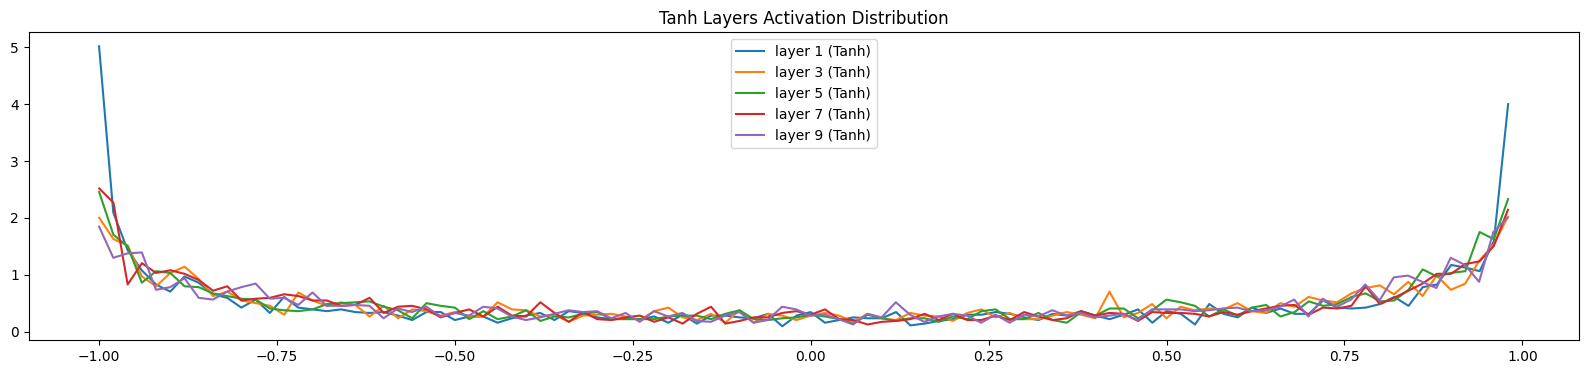

In [238]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 	# exclude output layer
	if isinstance(layer, Tanh):
		t = layer.out
		print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Tanh Layers Activation Distribution');

layer 1 (Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 7 (Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (Tanh): mean +0.00, std 0.00, saturated: 0.00%


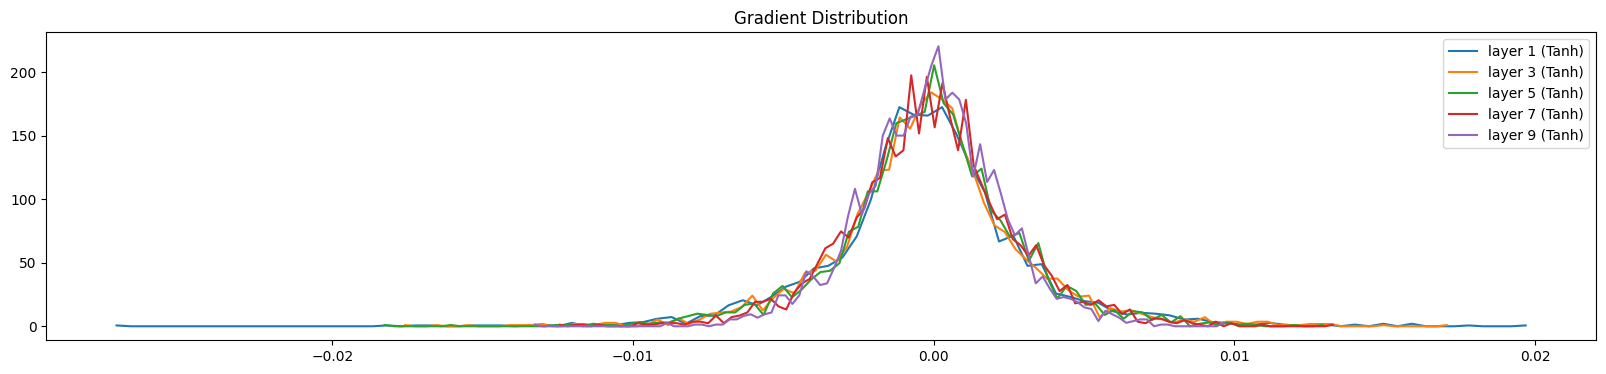

In [239]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 	# exclude output layer
	if isinstance(layer, Tanh):
		t = layer.out.grad
		print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Gradient Distribution');

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005291e-02 | grad:data ratio 3.214557e-02
weight (100, 100) | mean +0.000033 | std 7.821214e-03 | grad:data ratio 4.653364e-02
weight (100, 100) | mean -0.000107 | std 6.655623e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086042e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean -0.000000 | std 2.056585e-02 | grad:data ratio 2.909910e-01


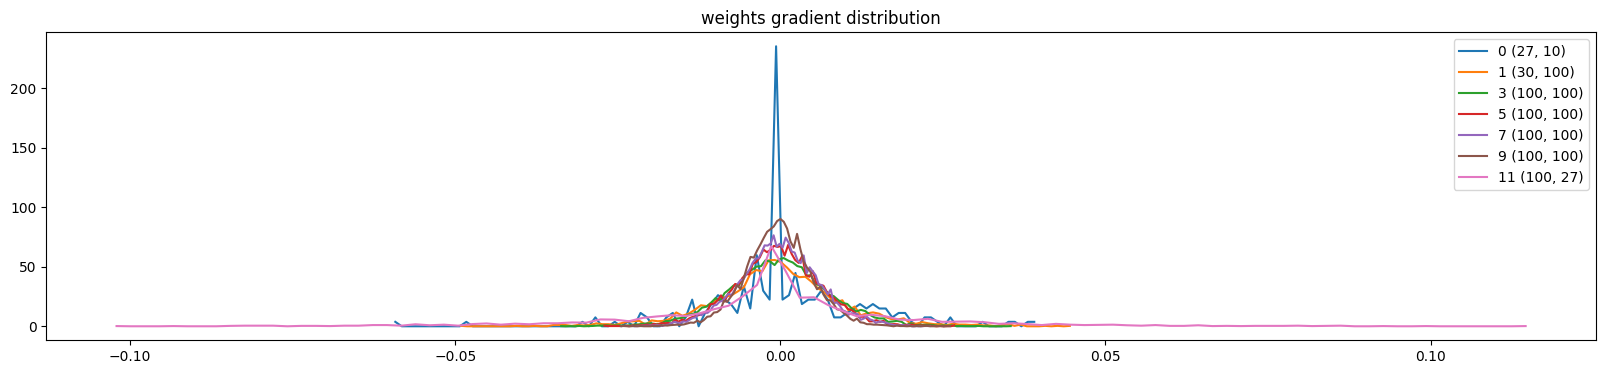

In [240]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

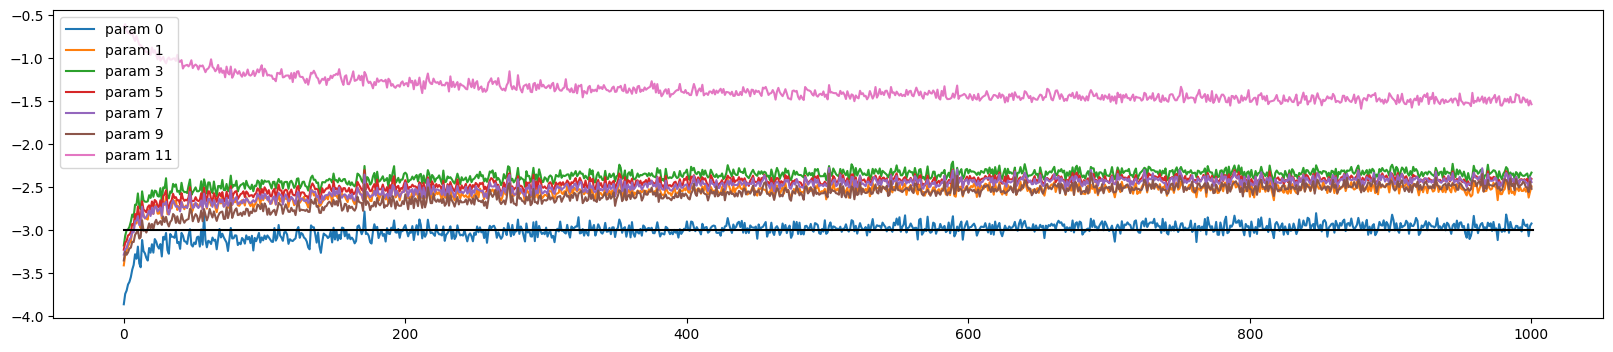

In [241]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


Introducing Batch Normalization

In [260]:
layers = [
	Linear((n_emb * block_size), n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear((n_hidden), n_hidden), BatchNorm1D(n_hidden), Tanh(),
	Linear((n_hidden), vocab_size), BatchNorm1D(vocab_size)
]

with torch.no_grad():
	# last batch norm layer
	layers[-1].gamma *= 0.1
	# all other layers, apply gain
	for layer in layers[:-1]:
		if isinstance(layer, Linear):
			layer.weight *= 1 # gain for tanh
			# layer.weight *= 5/3 # gain for tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # print no of trainable paramters
for p in parameters:
	p.requires_grad = True

47551


In [276]:
lre = torch.linspace(-1, -3, epochs)
lrs = 10**lre
lri = []
lossi = []
stepi = []

# training
epochs = 200000
batch_size = 32
lossi = []
ud = []

for i in range(epochs):
	# minibatch construction
	ix = torch.randint(0, in_train.shape[0], (batch_size,), generator=g)
	in_batch, out_batch = in_train[ix], out_train[ix]

	# forward pass
	emb = C[in_batch] # batch of character embeddings
	x = emb.view(emb.shape[0], -1) # concat vectors
	for layer in layers:
		x = layer(x)
	loss = F.cross_entropy(x, out_batch) # loss function

	# backward pass
	for layer in layers:
		layer.out.retain_grad()
	for p in parameters:
		p.grad = None
	loss.backward()

	# update
	# lr = lrs[i] 						# gradual decrease
	lr = 0.01 if i < 100000 else 0.001
	for p in parameters:
		p.data += -lr * p.grad

	# track stats
	if i % 10000 == 0:
		print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	with torch.no_grad():
		ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

	if i >= 1000:
		break

      0/ 200000: 2.7403


layer 2 (Tanh): mean -0.00, std 0.63, saturated: 3.22%
layer 5 (Tanh): mean -0.00, std 0.64, saturated: 2.72%
layer 8 (Tanh): mean +0.00, std 0.65, saturated: 2.62%
layer 11 (Tanh): mean -0.00, std 0.65, saturated: 2.41%
layer 14 (Tanh): mean +0.01, std 0.65, saturated: 2.03%


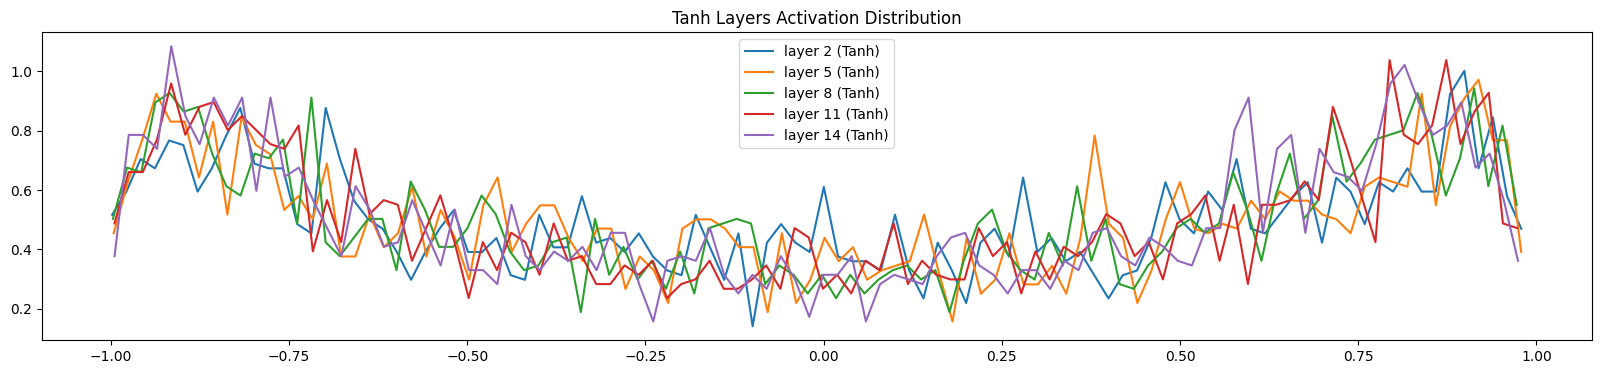

In [277]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 	# exclude output layer
	if isinstance(layer, Tanh):
		t = layer.out
		print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Tanh Layers Activation Distribution');

layer 2 (Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 8 (Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 11 (Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 14 (Tanh): mean -0.00, std 0.00, saturated: 0.00%


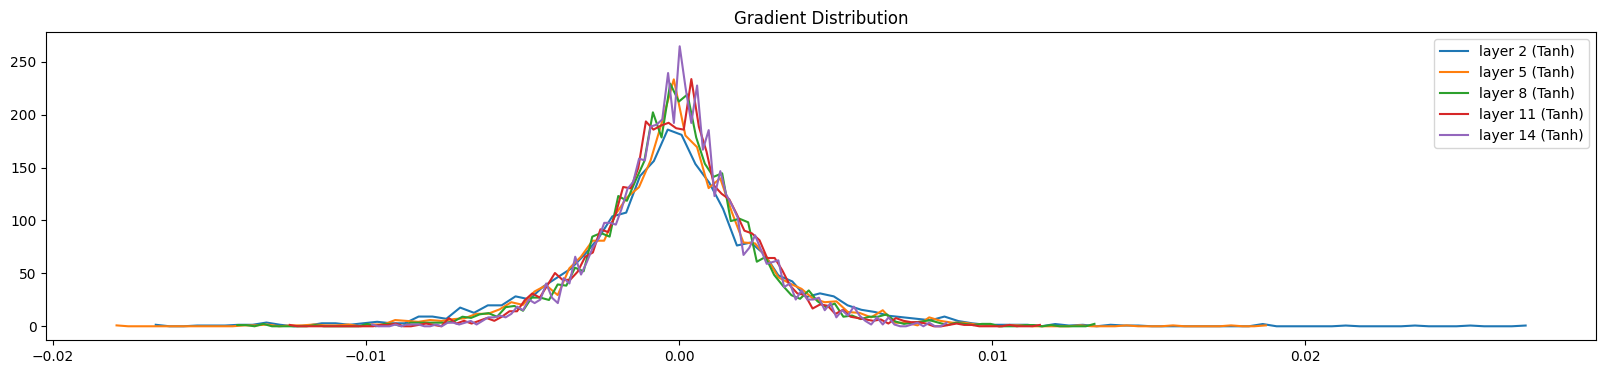

In [278]:
# visualize histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): 	# exclude output layer
	if isinstance(layer, Tanh):
		t = layer.out.grad
		print('layer %d (%s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
		hy, hx = torch.histogram(t, density=True)
		plt.plot(hx[:-1].detach(), hy.detach())
		legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends);
plt.title('Gradient Distribution');

weight   (27, 10) | mean +0.000000 | std 1.236455e-02 | grad:data ratio 1.232474e-02
weight  (30, 100) | mean -0.000258 | std 1.342887e-02 | grad:data ratio 7.223321e-02
weight (100, 100) | mean -0.000088 | std 9.170245e-03 | grad:data ratio 8.872212e-02
weight (100, 100) | mean +0.000158 | std 7.694814e-03 | grad:data ratio 7.390825e-02
weight (100, 100) | mean -0.000030 | std 6.688870e-03 | grad:data ratio 6.586030e-02
weight (100, 100) | mean -0.000024 | std 6.335235e-03 | grad:data ratio 6.173968e-02
weight  (100, 27) | mean -0.000022 | std 1.236119e-02 | grad:data ratio 1.111665e-01


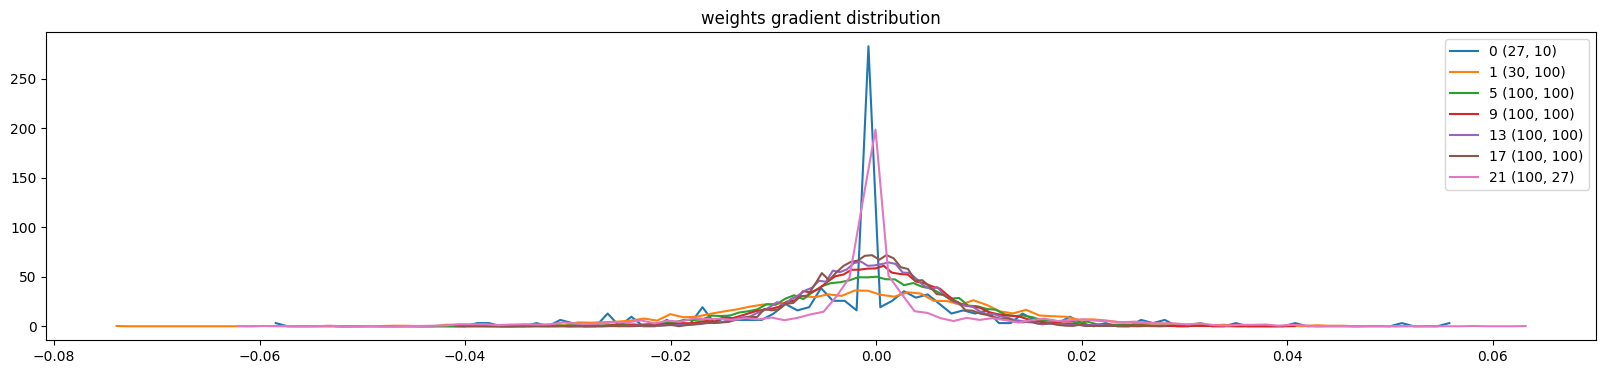

In [279]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

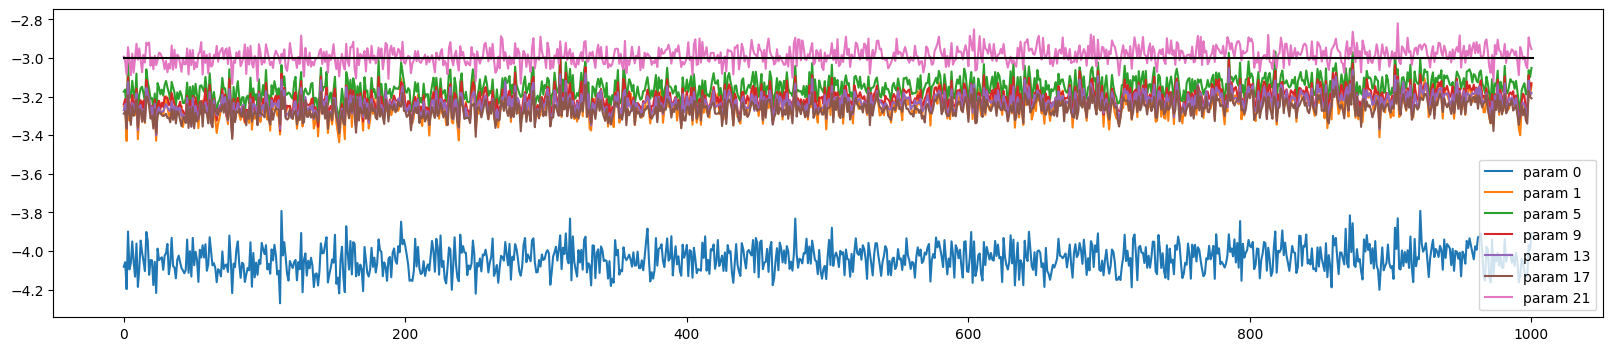

In [280]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
